# Project 3a

The final part of the project will ask you to perform your own data science project to classify a new dataset.

## Submission Details

**Project is due June 14th at 11:59 pm (Friday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend printing the notebook using [$\LaTeX$](https://www.latex-project.org/)**

## Loading Essentials and Helper Functions 

In [2]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

## Background: Dataset Information (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (male/female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [4]:
# Preprocess Data

# Load Data
data = pd.read_csv("datasets/heartdisease.csv")

# Transform target feature into numerical
le = LabelEncoder()
data["target"] = le.fit_transform(data["sick"])
data["sex"] = le.fit_transform(data["sex"])
data = data.drop(["sick"], axis=1)

# Split target and data
y = data["target"]
x = data.drop(["target"], axis=1)

# Train test split
# 40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(
    x, y, test_size=0.4, stratify=y, random_state=0
)

# Feature Transformation
# This is the only change from project 2 since we replaced standard scaler to minmax
# This was done to ensure that the numerical features were still of the same scale
# as the one hot encoded features
num_pipeline = Pipeline([("minmax", MinMaxScaler())])

heart_num = train_raw.drop(
    ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"], axis=1
)
numerical_features = list(heart_num)
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories="auto"), categorical_features),
    ]
)

# Transform raw data|
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)  # Note that there is no fit calls

# Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [5]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [6]:
# Baseline accuracy of using the majority class
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
target
0    66
1    56
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.541


## 1. (25 pts) Decision Trees

### 1.1. [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use `random_state = SEED` so that your results match ours.

In [8]:
# TODO
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=SEED)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.713115
Confusion Matrix: 
 [[54 12]
 [23 33]]


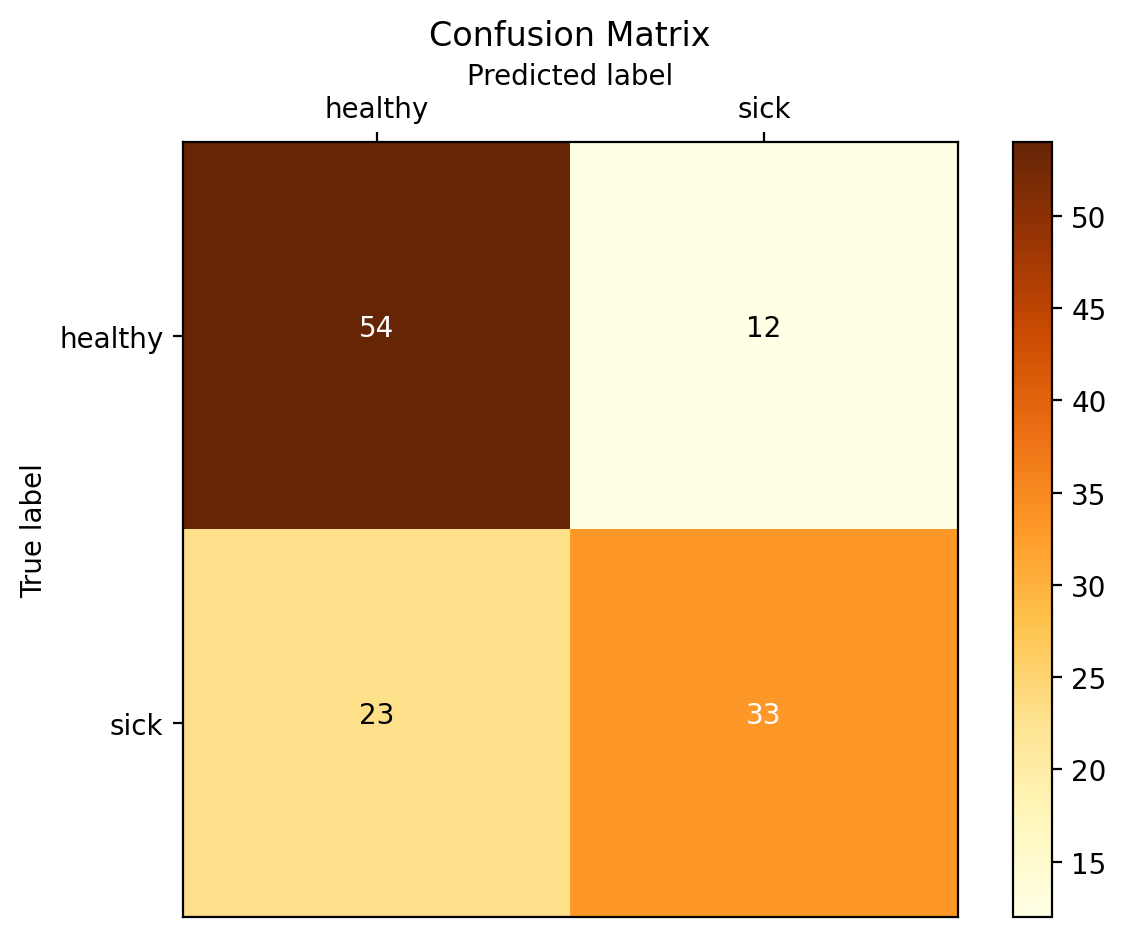

In [9]:
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["healthy", "sick"])

### 1.2. [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.5, 0.8333333333333334, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.25, 0.5, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

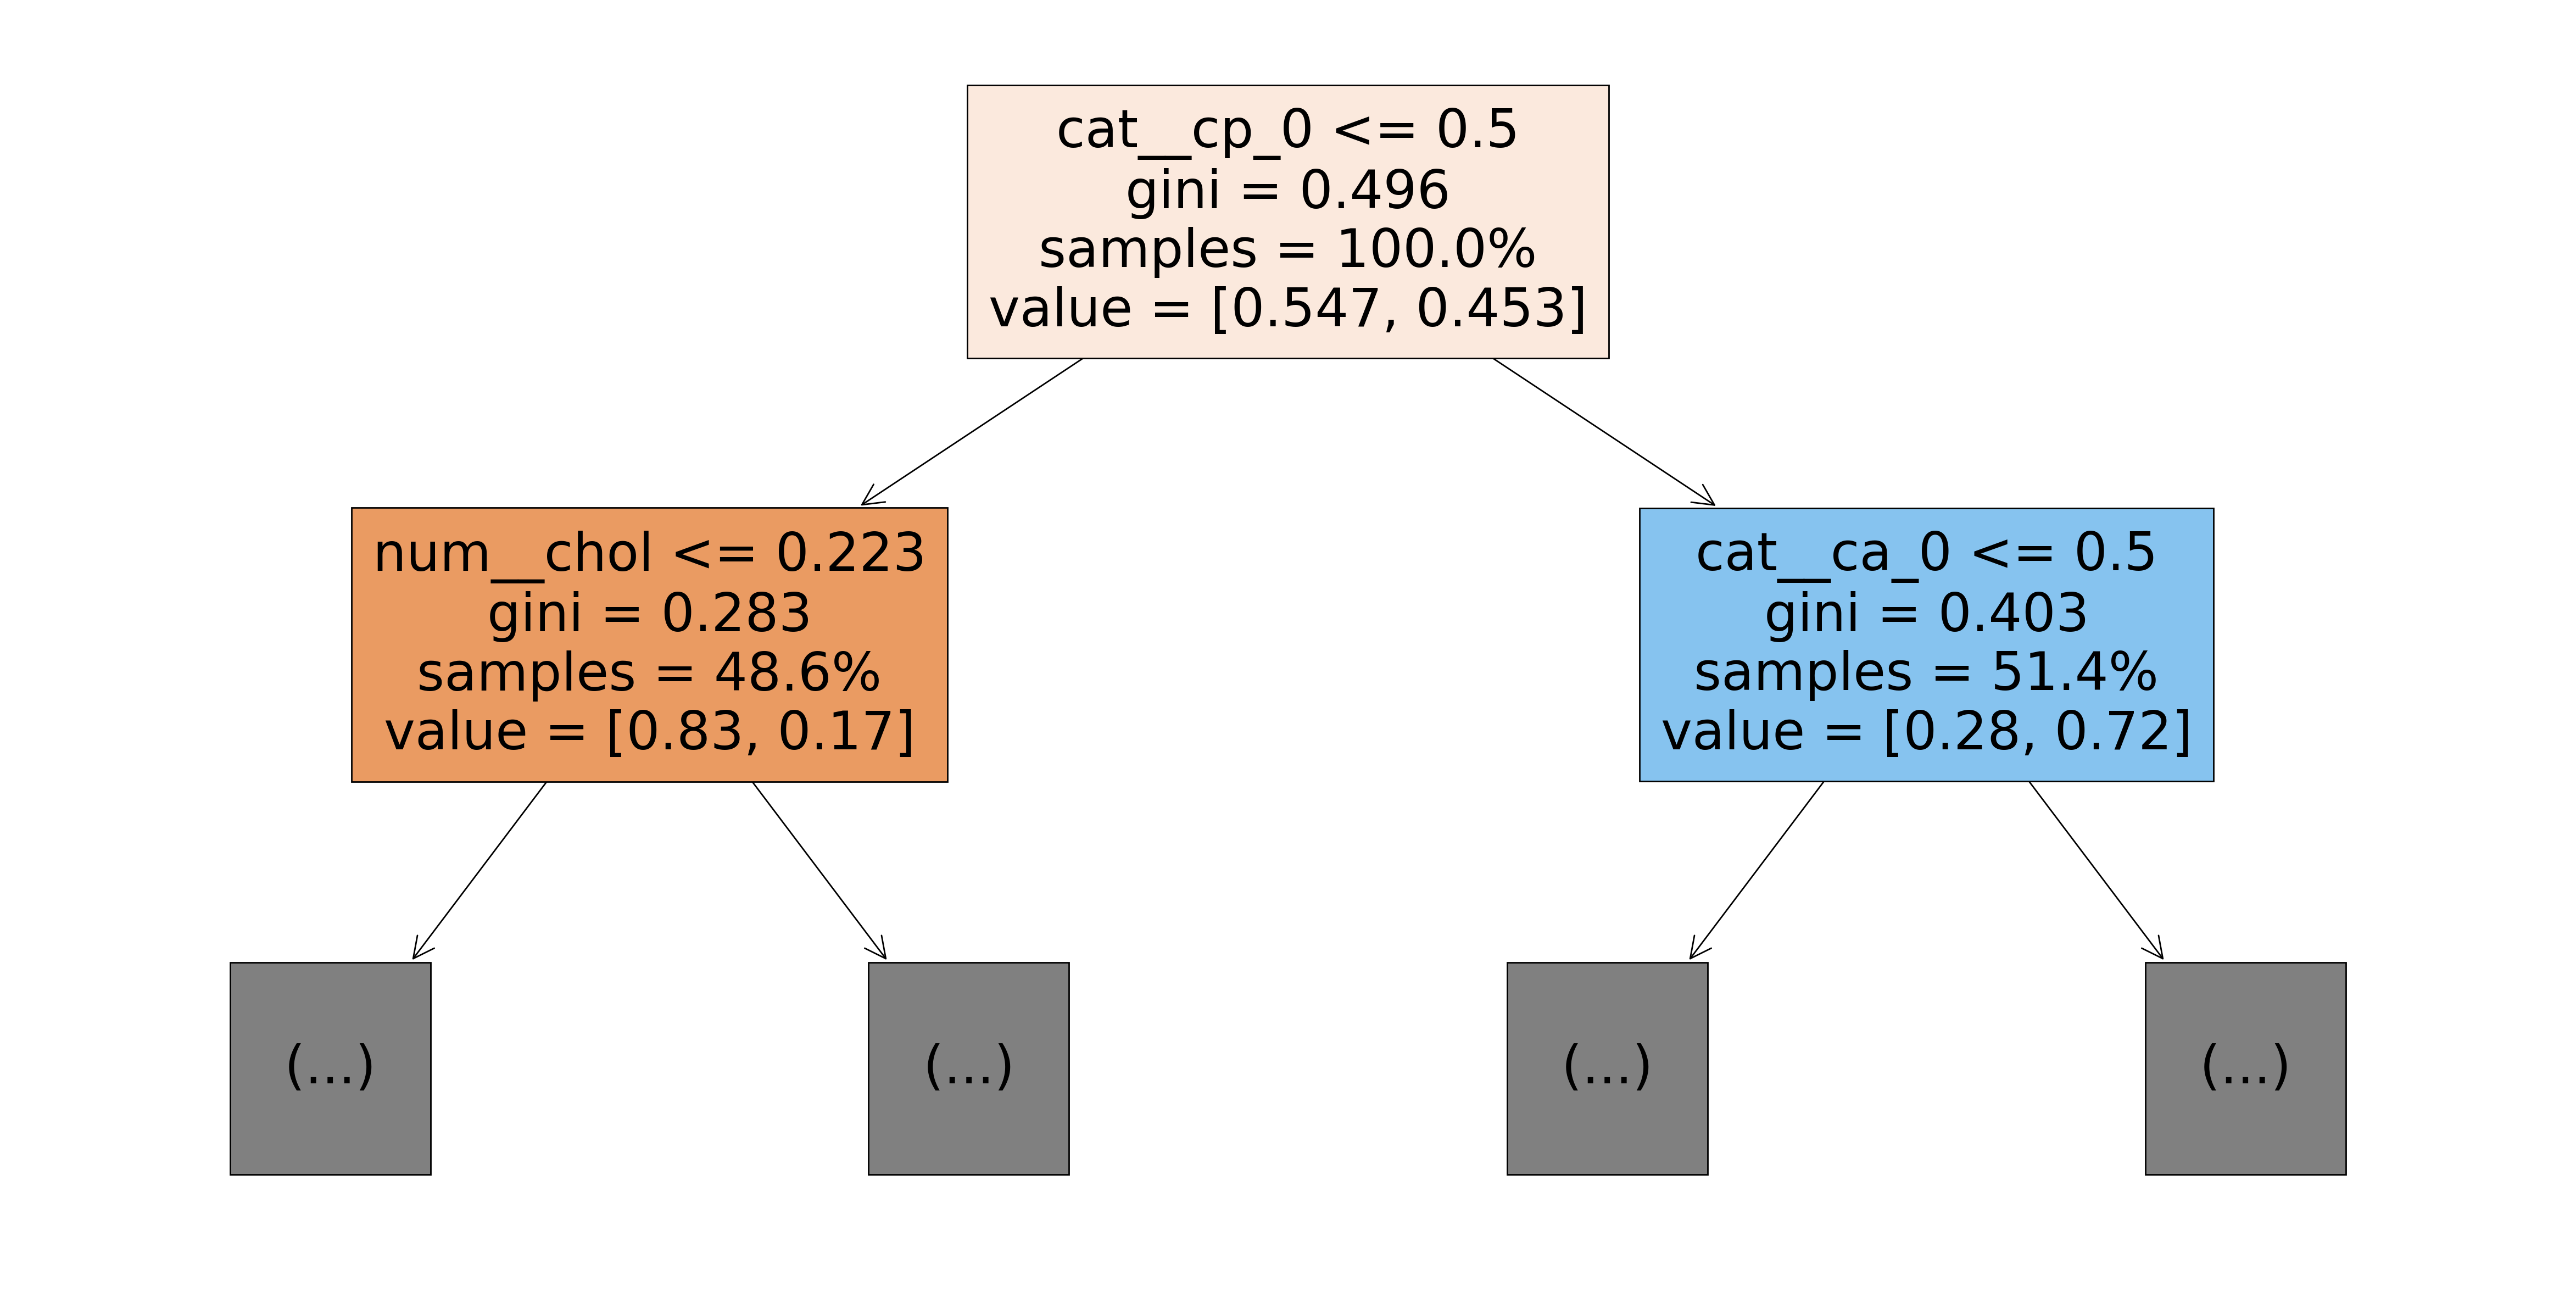

In [10]:
# TODO
plt.figure(figsize=(30,15))

tree.plot_tree(clf,max_depth=1,proportion=True,feature_names=feature_names,filled=True)

In [11]:
print(export_text(clf, feature_names=feature_names))

|--- cat__cp_0 <= 0.50
|   |--- num__chol <= 0.22
|   |   |--- class: 0
|   |--- num__chol >  0.22
|   |   |--- cat__slope_2 <= 0.50
|   |   |   |--- num__trestbps <= 0.42
|   |   |   |   |--- cat__cp_2 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cat__cp_2 >  0.50
|   |   |   |   |   |--- cat__exang_0 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cat__exang_0 >  0.50
|   |   |   |   |   |   |--- num__chol <= 0.24
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- num__chol >  0.24
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- num__trestbps >  0.42
|   |   |   |   |--- num__age <= 0.83
|   |   |   |   |   |--- num__oldpeak <= 0.06
|   |   |   |   |   |   |--- cat__fbs_1 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- cat__fbs_1 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num__oldpeak >  0.06
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- 

**What is the gini index improvement of the first split?**

Response: #TODO

 G(parent) = 1 - (0.547)^2 - (0.453)^2 = 0.495
 G(Child 1) = 1 - (0.83)^2 - (0.17)^2 = 0.283
 G(Child 2) = 1 - (0.28)^2 - (0.72)^2 = 0.403
 
Gain = G(parent) - (0.486 x 0.495 + 0.514 x 0.403) = 0.047288
 

### 1.3 [5 pts] Plot the importance of each feature for the Decision Tree

<Axes: >

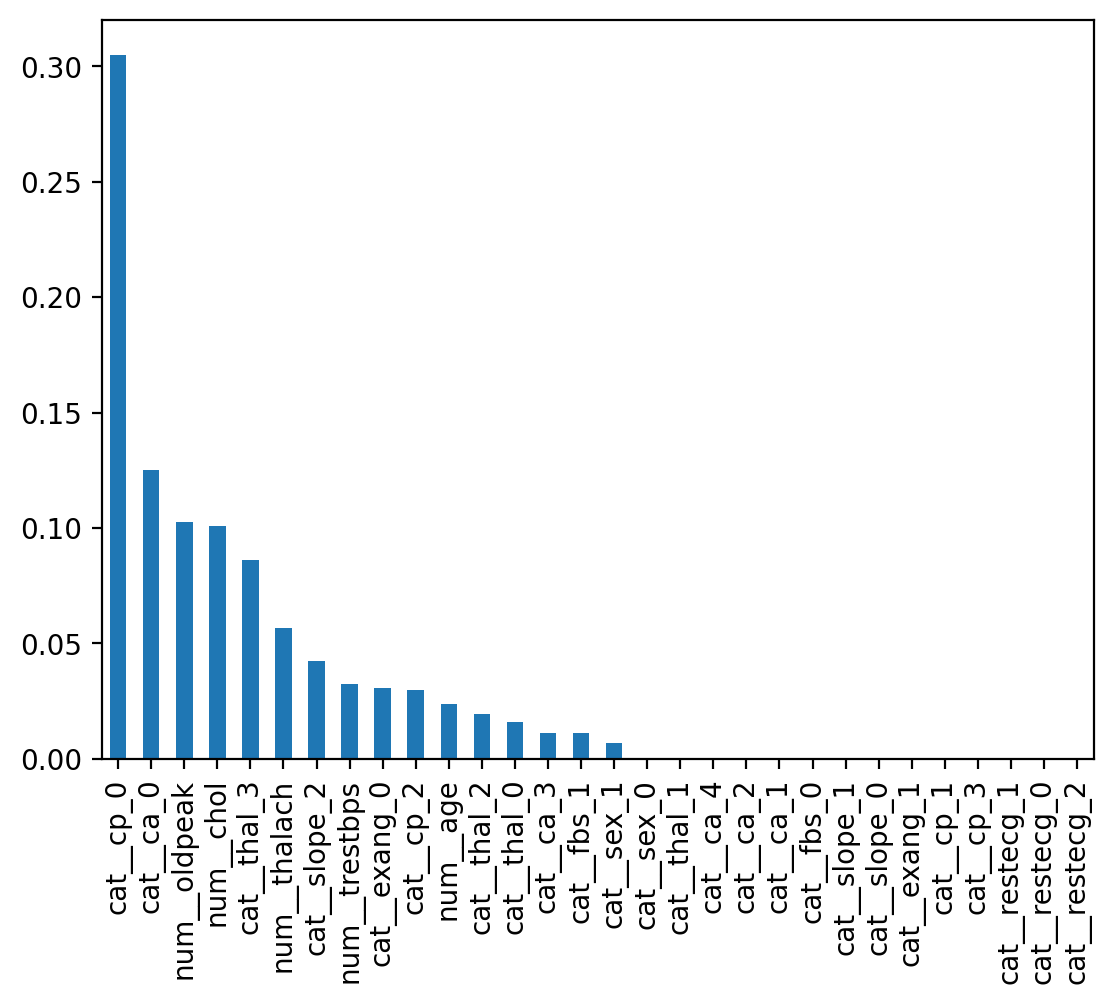

In [12]:
# TODO
imp_pd = pd.Series(data=clf.feature_importances_, index=feature_names)
imp_pd = imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: 

### 1.4 [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a `GridSearchCV` with 5-Fold Cross Validation for the Decision Tree. Find the best model parameters for accuracy amongst the following:

- `max_depth` = [2, 4, 8, 16, 32]
- `min_samples_split` = [2, 4, 8, 16]
- `criterion` = [`gini`, `entropy`]

After using `GridSearchCV`, Print the **best 5 models** with the following parameters: `rank_test_score`, `param_max_depth`, `param_min_samples_split`, `param_criterion`, `mean_test_score`, `std_test_score`.


In [13]:
# TODO
from sklearn.model_selection import GridSearchCV

dt_param_grid = {
    "max_depth": [2, 4, 8, 16, 32],
    "min_samples_split": [2, 4, 8, 16],
    "criterion": ["gini", "entropy"]
}

kf = KFold(n_splits = 5, random_state = None)
clf = DecisionTreeClassifier()

grid_dt = GridSearchCV(clf, dt_param_grid, cv=kf,scoring="accuracy")
grid_dt.fit(train, target)

res_dt = pd.DataFrame(grid_dt.cv_results_)


In [14]:
best_5_models = res_dt.loc[:, ["rank_test_score", "param_max_depth", "param_min_samples_split", "param_criterion", "mean_test_score", "std_test_score"]].nsmallest(5, 'rank_test_score')
print(best_5_models)

    rank_test_score param_max_depth param_min_samples_split param_criterion  \
37                1              32                       4         entropy   
16                2              32                       2            gini   
17                3              32                       4            gini   
8                 4               8                       2            gini   
13                5              16                       4            gini   

    mean_test_score  std_test_score  
37         0.773874        0.081655  
16         0.773574        0.075008  
17         0.768168        0.076974  
8          0.768018        0.100120  
13         0.762913        0.095483  


**Using the best model you have, report the test accuracy and print out the confusion matrix**

In [16]:
# FIXME
#best_model = grid_dt.best_estimator_
#predicted = best_model.predict(test)

#test_acc = metrics.accuracy_score(target_test, predicted)
#print(test_acc)


0.7213114754098361


In [15]:

predicted = grid_dt.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.696721


## 2. (20 pts) Multi-Layer Perceptron

### 2.1 [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(50, 50) and max_iter = 1000. **Report the accuracy and print the confusion matrix**. Make sure to set `random_state=SEED`. 

In [16]:
# TODO
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.819672
Confusion Matrix: 
 [[62  4]
 [18 38]]


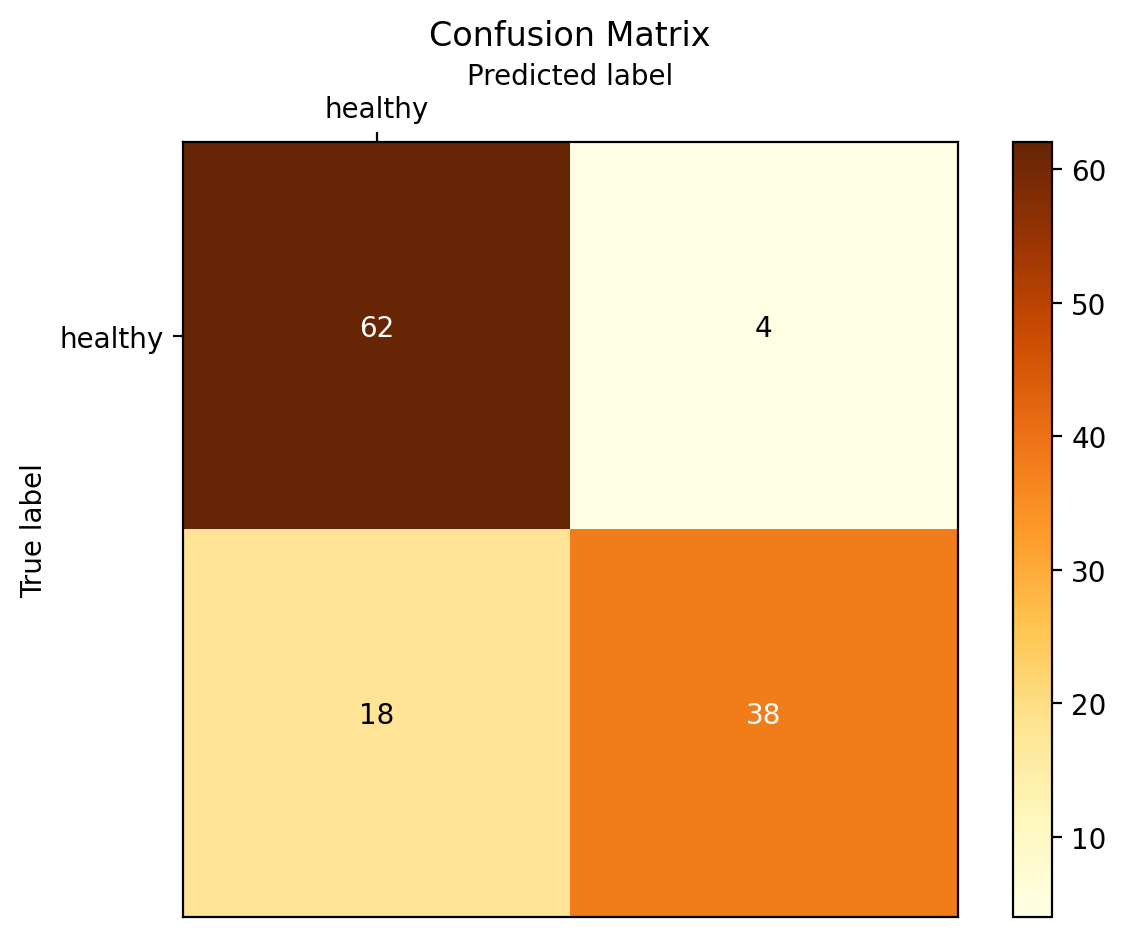

In [17]:
print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["healthy"])

### 2.2 [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [18]:
# TODO


dt_clf = DecisionTreeClassifier(random_state=SEED)
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)

start_time_dt_train = time.time()
dt_clf.fit(train, target)
end_time_dt_train = time.time()

training_time_dt = end_time_dt_train - start_time_dt_train

start_time_mlp_train = time.time()
mlp_clf.fit(train, target)
end_time_mlp_train = time.time()

training_time_mlp = end_time_mlp_train - start_time_mlp_train

print("Training Time - Decision Tree: {:.3f}s".format(training_time_dt))
print("Training Time - MLP: {:.3f}s".format(training_time_mlp))
if training_time_dt < training_time_mlp:
    print("The Decision Tree was faster for training.")
else:
    print("The MLP was faster for training.")

Training Time - Decision Tree: 0.003s
Training Time - MLP: 2.306s
The Decision Tree was faster for training.


Decision Trees were much quicker than the MLP.

### 2.3 [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response:

Ability to capture complex patterns in the data. MLPs are capable of learning non-linear relationships between features, which makes them suitable for tasks that involve complex decision boundaries. They can handle more complex and high-dimensional data compared to DTs.

Computationally expensive compared to DTs. MLPs have multiple layers and connections, so they need more time to train and predict (as shown above). MLPs may also be more prone to overfitting, especially for a limited data pool.

## 3 (35 pts) PCA

### 3.1 [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [19]:
# TODO
from sklearn.decomposition import PCA

pca = PCA()
pca_pipe = Pipeline(
    [
        (
            "scaler",
            StandardScaler(),
        ),  # Scikit learn PCA does not standardize so we need to add
        ("pca", pca),
    ]
)

# Create an instance of the PCA class with n_components=10
pca_pipe = PCA(n_components=10)

# Fit the PCA model to the train data
pca_pipe.fit(train)

# Get the principal components
principal_components = pca_pipe.components_

# Print out the 10 principal components
print("Principal Components:")
for component in principal_components:
    print(component)


Principal Components:
[ 0.06099466  0.04034864  0.01924581 -0.1017322   0.11071541 -0.12331434
  0.12331434  0.34265332 -0.13458918 -0.20936122  0.00129708 -0.01288493
  0.01288493  0.19693729 -0.19855631  0.00161902 -0.35054419  0.35054419
  0.04595587  0.29412324 -0.34007911 -0.20553518  0.07463263  0.08348053
  0.06758334 -0.02016132 -0.00039038  0.04438528 -0.31408112  0.27008622]
[ 0.05231789  0.02890251  0.03826504 -0.00733246 -0.0037285   0.44442215
 -0.44442215  0.07362246 -0.03171478 -0.02860787 -0.01329982 -0.02106535
  0.02106535  0.42589374 -0.44447634  0.0185826   0.0184908  -0.0184908
 -0.02183111  0.1435457  -0.1217146   0.02011775 -0.03199655  0.03699266
  0.00382438 -0.02893824  0.00336806  0.00301279  0.29007107 -0.29645192]
[-0.0427616  -0.03742143  0.00354063 -0.04733566  0.01801283  0.30699875
 -0.30699875  0.09347247  0.0329172  -0.0989118  -0.02747786  0.19990151
 -0.19990151 -0.43118048  0.40996579  0.0212147  -0.13223456  0.13223456
 -0.02514842  0.32090865 -0.

### 3.2 [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [20]:
# TODO
explained_variance_ratio_ = pca_pipe.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio_.cumsum()

print("Percentage of Variance Explained by the Top 10 Principal Components:")
for i, ratio in enumerate(explained_variance_ratio_[:10]):
    print("Principal Component {}: {:.2f}%".format(i+1, ratio*100))

print("Cumulative Explained Variance Ratio:")
for i, ratio in enumerate(cumulative_variance_ratio[:10]):
    print("Components {}: {:.2f}%".format(i+1, ratio*100))

Percentage of Variance Explained by the Top 10 Principal Components:
Principal Component 1: 23.86%
Principal Component 2: 13.60%
Principal Component 3: 10.03%
Principal Component 4: 8.24%
Principal Component 5: 7.50%
Principal Component 6: 6.59%
Principal Component 7: 5.92%
Principal Component 8: 4.94%
Principal Component 9: 4.04%
Principal Component 10: 2.99%
Cumulative Explained Variance Ratio:
Components 1: 23.86%
Components 2: 37.47%
Components 3: 47.50%
Components 4: 55.74%
Components 5: 63.23%
Components 6: 69.83%
Components 7: 75.75%
Components 8: 80.68%
Components 9: 84.72%
Components 10: 87.72%


### 3.3 [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [21]:
# TODO
train_new = pca_pipe.fit_transform(train)
test_new = pca_pipe.transform(test)



### 3.4 [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy:    0.811475
Confusion Matrix: 
 [[59  7]
 [16 40]]


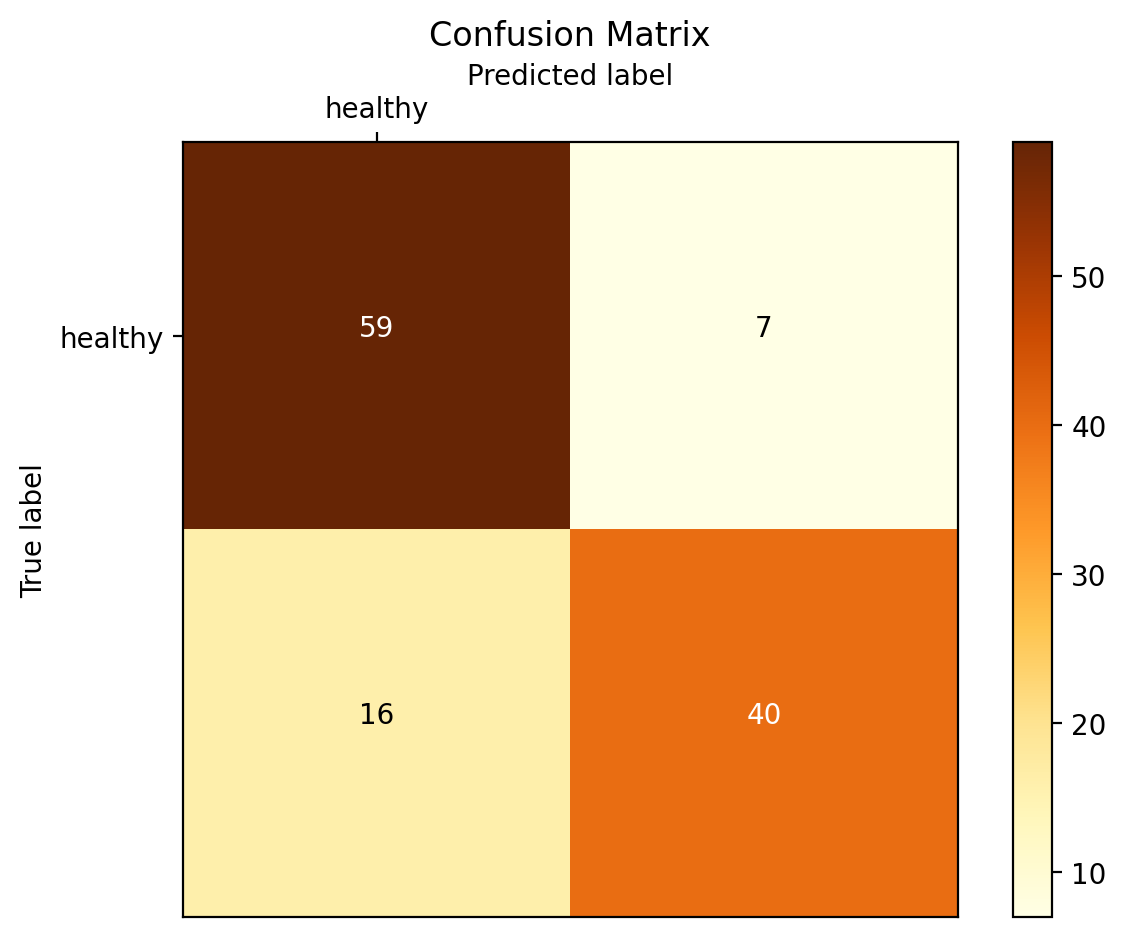

In [22]:
# TODO
clf_pca = DecisionTreeClassifier(random_state=SEED)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["healthy"])

**Does the model perform better with or without PCA?**

Response:
The model performs a lot better with PCA (Accuracy 0.811475)

### 3.5 [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy:    0.803279
Confusion Matrix: 
 [[61  5]
 [19 37]]


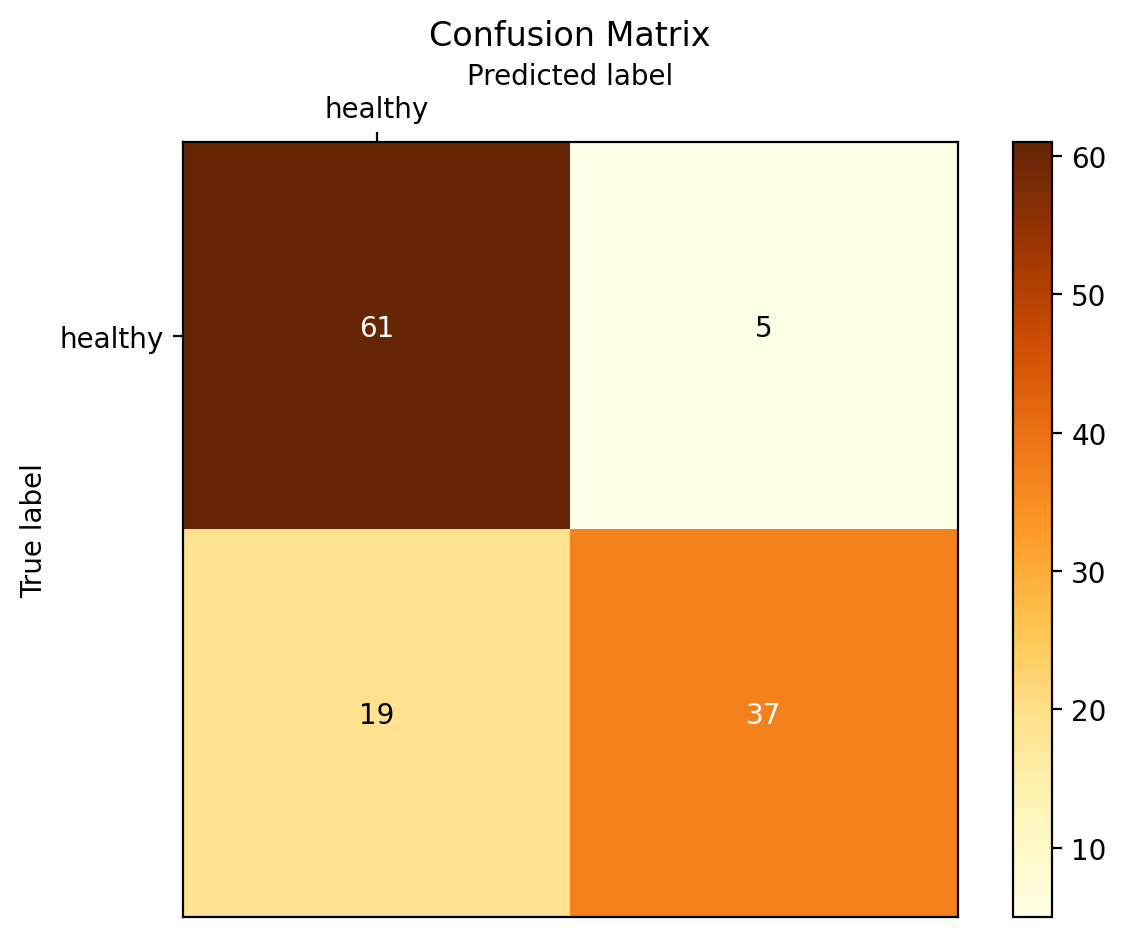

In [23]:
# TODO
train_new = pca_pipe.transform(train)
test_new = pca_pipe.transform(test)
clf_pca = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)

clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["healthy"])


**Does the model perform better with or without PCA?**

Response:
#TODO
The model performs better with PCA

### 3.6 [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response:

Dimensionality reduction while retaining the most important information. Transforms the data into a lower-dimensional space to simplify complex datasets and increase efficiency

Feature interpretation: Creates new vars called principal components, which are linear combinations of original features. Ordered by importance in explaining variance which makes it easier to interpret most significant factors

Can reduce interpretability of transformed data. Principal components may not have direct correspondence to real-world concepts.

Information loss: Dimensionality reduction can lead to loss of information. It is essential to balance reduction in dimensionality with the amount of variance we are sacrificing.



## 4. (20 pts) K-Means Clustering

### 4.1 [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and `random_state = SEED`.

In [24]:
# TODO
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=SEED)
kmeans.fit(train)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")



Inertia: 489.0488065162733


### 4.2 [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 25. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use `random_state = SEED`.

In [25]:
# TODO
ks = list(range(2,25))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(train)
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_:.2f}")

Inertia for K = 2: 619.30
Inertia for K = 3: 561.53
Inertia for K = 4: 515.09
Inertia for K = 5: 489.05
Inertia for K = 6: 470.33
Inertia for K = 7: 444.00
Inertia for K = 8: 426.30
Inertia for K = 9: 407.75
Inertia for K = 10: 401.96
Inertia for K = 11: 387.55
Inertia for K = 12: 371.74
Inertia for K = 13: 359.22
Inertia for K = 14: 350.70
Inertia for K = 15: 348.51
Inertia for K = 16: 342.60
Inertia for K = 17: 328.49
Inertia for K = 18: 319.41
Inertia for K = 19: 310.68
Inertia for K = 20: 304.17
Inertia for K = 21: 296.25
Inertia for K = 22: 288.43
Inertia for K = 23: 280.92
Inertia for K = 24: 271.06


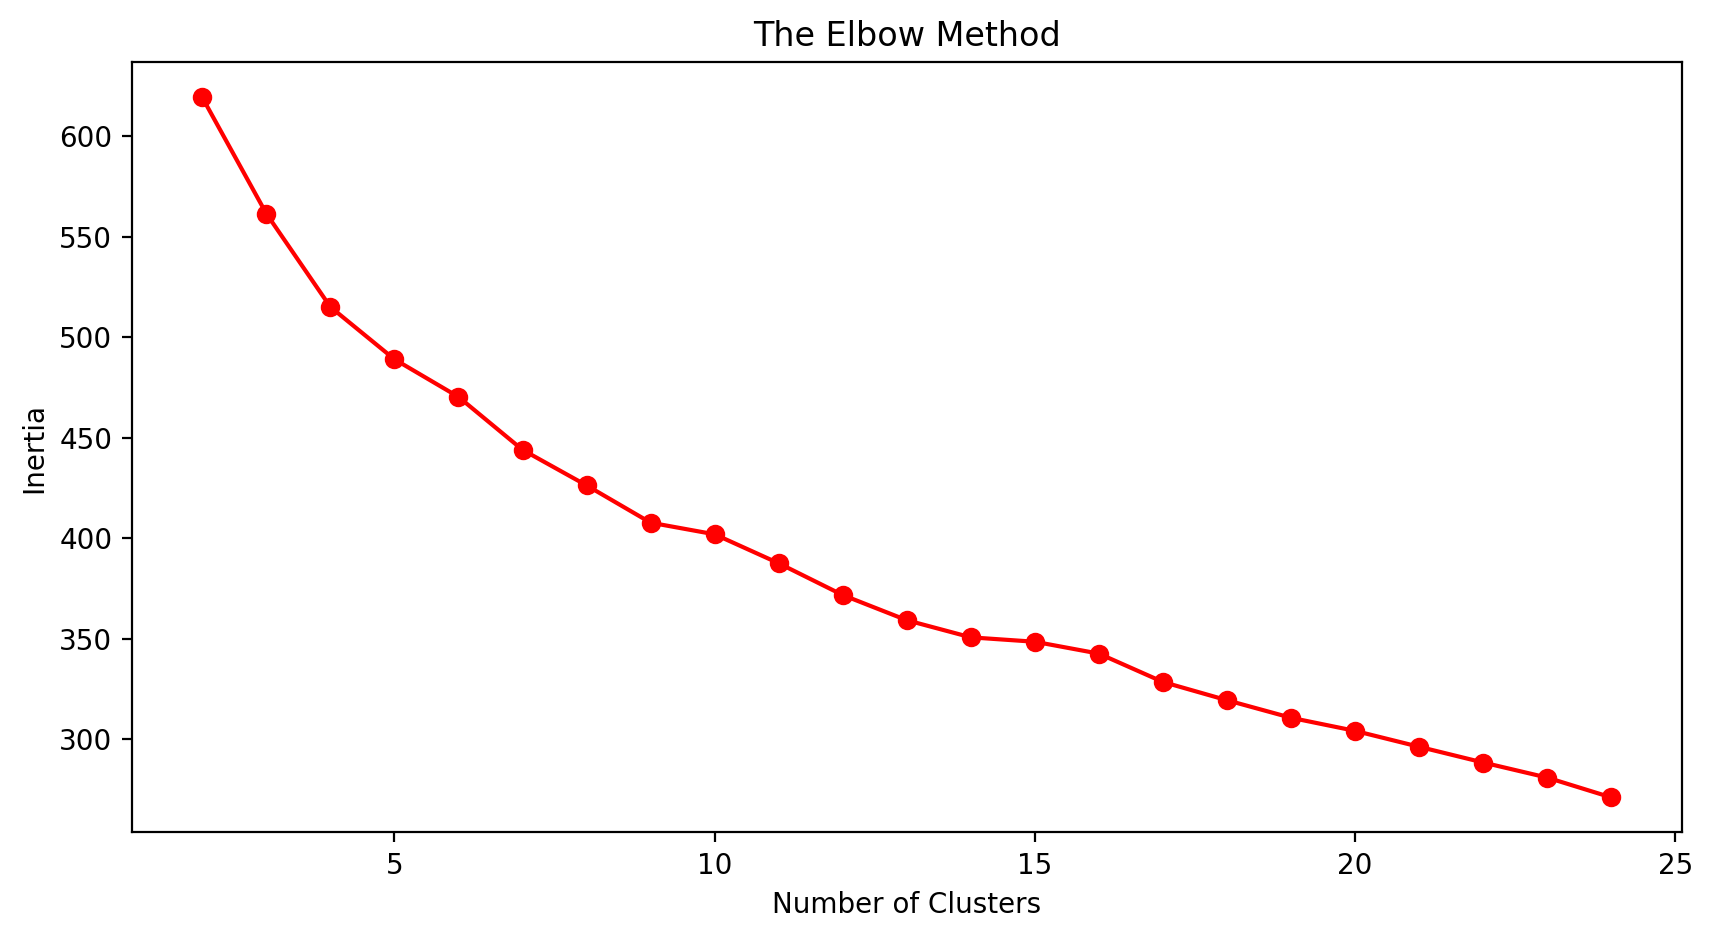

In [26]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia, marker='o', color='red')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

From the plot, we can guess that the best cluster size is somewhere between 5 and 10.

### 4.3 [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [28]:
# TODO
train_new = pca_pipe.fit_transform(train)
test_new = pca_pipe.transform(test)

kmeans = KMeans(n_clusters=5, random_state=SEED)
kmeans.fit(train_new)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")



Inertia: 411.3696894350429


In [29]:
ks = list(range(2,25))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(train_new)
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_:.2f}")

Inertia for K = 2: 526.90
Inertia for K = 3: 481.68
Inertia for K = 4: 433.93
Inertia for K = 5: 411.37
Inertia for K = 6: 375.19
Inertia for K = 7: 382.90
Inertia for K = 8: 342.35
Inertia for K = 9: 325.73
Inertia for K = 10: 310.24
Inertia for K = 11: 287.75
Inertia for K = 12: 290.90
Inertia for K = 13: 278.22
Inertia for K = 14: 264.23
Inertia for K = 15: 256.32
Inertia for K = 16: 243.89
Inertia for K = 17: 233.95
Inertia for K = 18: 229.94
Inertia for K = 19: 227.57
Inertia for K = 20: 220.40
Inertia for K = 21: 213.26
Inertia for K = 22: 205.80
Inertia for K = 23: 196.45
Inertia for K = 24: 193.01


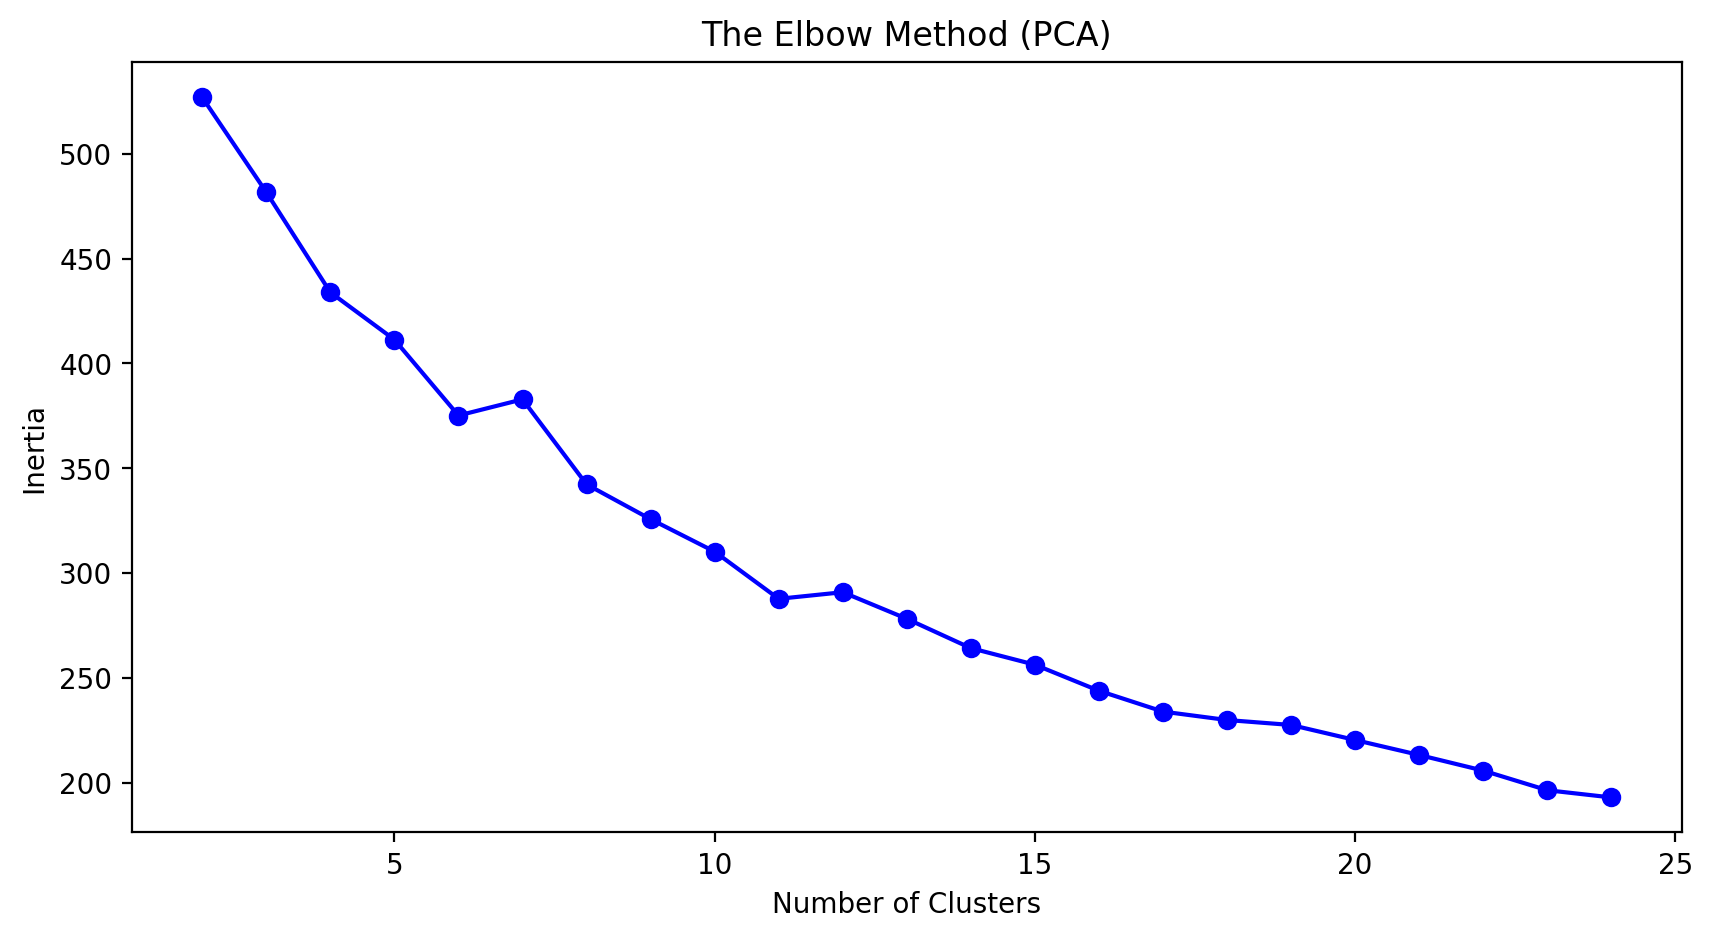

In [30]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia, marker='o', color='blue')
plt.title("The Elbow Method (PCA)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Similar to the previous experiment, we can guess that the best cluster size is somewhere between 5 and 10. Additionally, we see that the inertia is much smaller for every cluster size when using PCA features.

Response: ?